# Modeling Crop Yield
## Python modules

In [1]:
import warnings
import time
import os

import dask
from dask.distributed import Client

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

from pyhere import here

import math
import seaborn as sns

from pyhere import here

## Parameters
#### Choose a satellite.

For a description of the Landsat 8 mission, see the US Geological metadata [here.]()

For a description of the Sentinel 2 mission, see the US Geological metadata [here.]()

In [2]:
satellite = "landsat-c2-l2"
# satellite = "landsat-8-c2-l2"
# satellite = "sentinel-2-l2a"

#### Choose band combination.

For a description of **Landsat** bands, see the [US Geological Survey documentation here.](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites)

For a description of **Sentinel bands**, see the [US Geological Survey documentation here.](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2#:~:text=4%20bands%20at%2010%20meter,%2Dinfrared%20(842%20nm)

According to our results, bands **(insert band selection here)** result in the best model performance for Landsat, and **(insert band selection here)** result in the best model performance for Sentinel for the task of predicting maize yields in Zambia.

In [3]:
#bands = "2-3-4"
# bands = "2-3-4-8"
# bands = "1-2-3-4-5-6-7"
bands = "r-g-b-nir-swir16-swir22"
# bands = "2-3-4-5-6-7-8-11-12"

#### Choose the number of points that were featurized.

Each value in the following chunk represents the amount of thousands of points that were featurized in each respective feature file. These points represent a uniform subset of the spatial grid of Zambia. Points are spaced at uniform intervals for each selection, measured in kilometers in the longitudinal direction for each set of features. The kilometer distance interval differs for each selection below; 42,000 points results in the smallest uniform distance between points, and 4,000 points results in the greatest uniform distance between points. Selecting a greater quantity of points results in a denser spatial sample, which increases computational cost and time, but increases the spatial resolution of the model. Regardless of the quantity of points selected, each point is buffered by the same distance, resulting in a 1km^2 cell around each point.

These specific options point quantities is a result of uniformly increasing the distance between points in units of kilometers prior to matching satellite images to each point. These options represent the number of points that fall within the borders of Zambia, and the numbers have been rounded to the nearest thousandth for consistency in naming files. See the [CropMOSAIKS Featurization repository](https://github.com/cropmosaiks/Featurization) for more information regarding how these distances we calculated. 

In [4]:
# points = 15
points = 20

#### Choose to keep only areas with crops (`True`) or to keep all points (`False`)

Selecting `True` applies a "cropland mask" to the spatial grid of Zambia. This retains only the regions of the country in which maize is  grown, according to the **(insert source here)**. As a result, the spatial extent of the features that are fed into the model are highly subset for the specific task at hand: modeling maize yields. According to our results, selecting `True` **(insert increases or decreases here)** model performance.

Selecting `False` results in modeling with the maximum spatial extent of the features, with more generalized features as a result.

In [5]:
# crop_mask = True
crop_mask = False

Choose a weighted average (`True`) or a simple mean (`False`) to use when collapsing features to administrative boundary level.

In [6]:
#weighted_avg = True
weighted_avg = False

#### Choose which months to use in the model.

Note that months 10, 11, and 12 get pushed to the next year because the growing season (November - May) spans the calendar year. Maize is planted in November, starts to change color with maturity in May, and is harvested in June - August. According to our results, subsetting the months to **(insert month selection here)** increases model performance.

In [7]:
month_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# month_range = [      3, 4, 5, 6, 7, 8, 9            ]
# month_range = [         4, 5, 6, 7, 8, 9            ]
# month_range = [            5, 6, 7, 8, 9            ]
# month_range = [         4, 5, 6, 7, 8               ]
# month_range = [            5, 6, 7, 8               ]

#### Impute NA values by descending group levels (True) or `scikit learn`'s simple imputer (False)

Imputing "manually" by descending group levels imputes NA values in multiple "cascading" steps, decreasing the proportion of inoutated values with each step. First, the NA values are imputed at by both `year` and `district`, which should yield imputed values that most closely match the feature values that would be present in the data if there was no clouds obscuring the satellite images. Next, the remaining NA values that could not be imputed by both `year` and `district` are imputed by only `district`. Lastly, the remaining NA vlaues that could not be imputed by both `year` and `district` or by just `district` are imputed by `year` only. This option gives the user more control and transparency over how the imputation is executed.

Imputing using `scikit learn`'s simple imputer executes standard imputation, the details of which can be found in the `scikitlearn` documentation [here.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

In [8]:
impute_manual = True
# impute_manual = False

### Select month start

If using Landsat 8 satellite imagery and want to include 2013 imagery and you have data that overlaps with the 2013 month range, select `True`. This is necessary because the Landsat 8 mission data starts in month 4. Ensure month range selected is 4 - 9.

In [9]:
include_2013 = True
# include_2013 = False

### Unchanging parameters

The parameters in the following chunk are set for the country of Zambia for with 1000 features, regardless of the satellite selected. The start years for each satellite reflect the respective years that Landsat 8 and Sentinel 2A missions began.

The number of features is set to 1000 to serve as a staple parameter among the several other parameters varied during the model optimization process. Changing this parameter in the following code chunk will result in an error because featurizing landsat imagery for a different number of features was outside the scope of this project.

In [10]:
country_code = "ZMB"

# num_features = 1000
num_features = 1024

if satellite == "landsat-c2-l2":
    year_start = 2008
elif satellite == "landsat-8-c2-l2":
    year_start = 2013 # Landsat 8 only
else:
    year_start = 2015 # Sentinel
    
year_end = 2021
year_end_crops = 2021

data_dir = "/capstone/cropmosaiks/data"  
data_dir = here("data")  

feature_file_name = (f'{satellite}_bands-{bands}_{country_code}_{points}k-points_{num_features}-features')
# ZMB_cropland_percentage_20k-points
weight_file_name = (f'{country_code}_cropland_percentage_{points}k-points')

if points == "4":
    marker_sz = 60
elif points == "15":
    marker_sz = 15
elif points == "24":
    marker_sz = 10
else:
    marker_sz = 8

## Administrative boundaries 

Administrative boundaries reflect the **(insert number of districts in dataset)** district boundaries within the country of Zambia. A district can be likened to a state within the larger U.S.A. We subset the spatial grid to district level becuase the crop yield data is at the district level of specificity. The features are originally produced at higher spatial resolution, then summarized to the district level in order to train the model with ground-truth crop data. 

<AxesSubplot:>

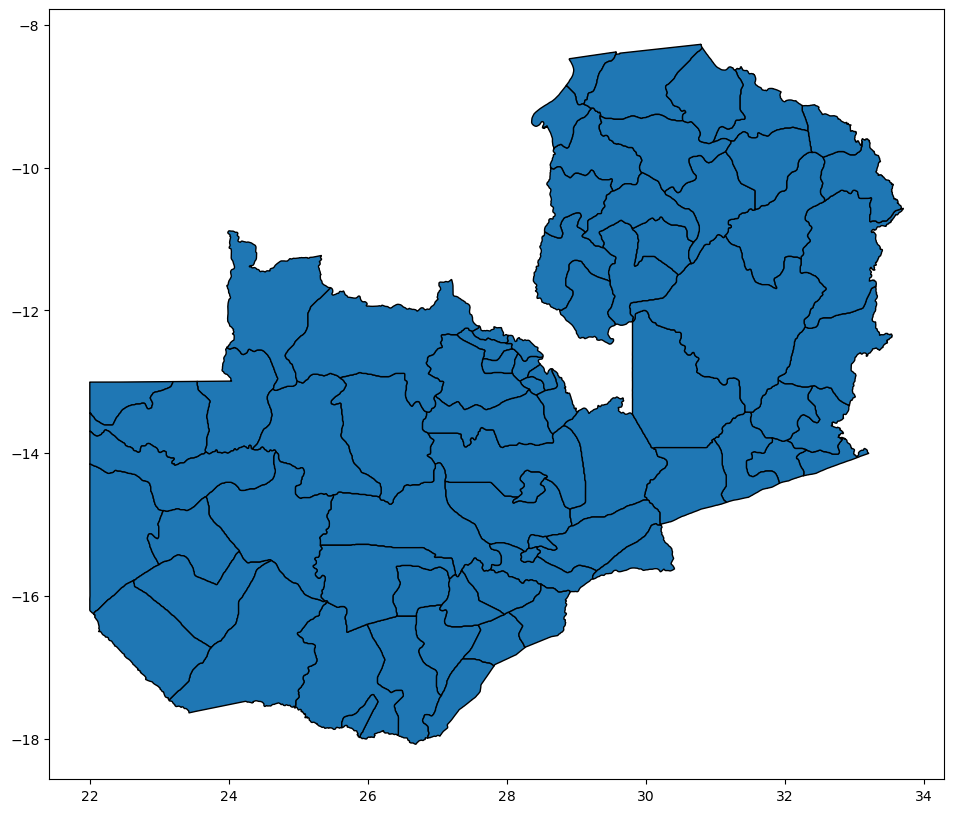

In [11]:
country_shp = geopandas.read_file(f'{data_dir}/geo_boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
country_shp.plot(figsize = (12,10), linewidth = 1, edgecolor = 'black' )
# country_shp.plot()

## Crop yield

Zambian maize yield data reflects the predicted annual maize yield provided by farmers in the month of May, when the maize matures and changes colors prior to harvest, which allows the farmers to estimate what their yield will be in the following months. These predictions are in units of metric tons per hectare and provide valuable insight to the Zambian government as they plan for the quanitites of food to import into the country in the future. For more metadata, see the websites for the [Central Statistics Office of Zambia (CSO)](https://www.zamstats.gov.zm/) and the [Summary statistics from CSO.](https://www.zamstats.gov.zm/agriculture-environment-statistics/)

In order to standardize the names of all districts shared between the geoboundaries and the crop yield data, we correct for spelling, dashes, and apostrophes. 


In [12]:
# crop_df_full = pd.read_csv(data_dir+'/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df_full = pd.read_csv(f'{data_dir}/crop_yield/cfs_maize_districts_zambia_2009_2022.csv')
crop_df_full = crop_df_full[crop_df_full.year <= year_end_crops]
# crop_df_full.district = crop_df_full.district.replace(
#     {"Itezhi-tezhi": 'Itezhi-Tezhi',
#      "Kapiri-Mposhi": 'Kapiri Mposhi',
#      "Kapiri mposhi": 'Kapiri Mposhi',
#      "Shang'ombo": 'Shangombo',
#      "Chienge": 'Chiengi'
#     }, regex=True)
crop_districts = crop_df_full.district.sort_values().unique().tolist()
crop_df = crop_df_full[['district', 'year', 'yield_mt']]
ln = len(crop_df[crop_df.year == 2016].district)
crop_df = crop_df.set_index('district')
ln
# crop_df_full
# crop_df

74

In [13]:
list(set(crop_districts) - set(country_districts))

['Mafinga', 'Ikelenge']

In [14]:
list(set(country_districts) - set(crop_districts))

[]

In [15]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

## Crop land

In [16]:
weights = pd.read_feather(f"{data_dir}/land_cover/{weight_file_name}.feather")
# weights

<AxesSubplot:>

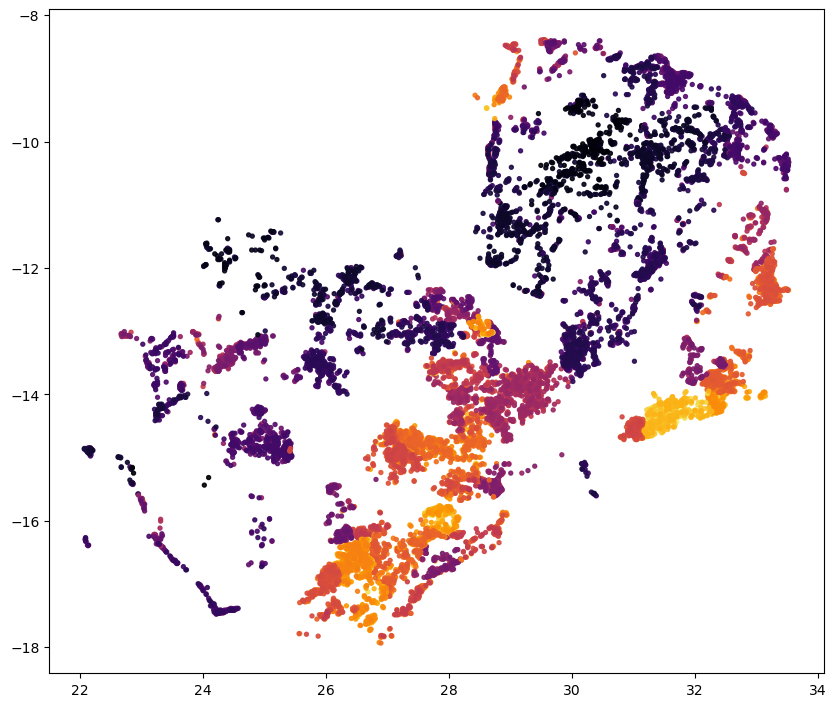

In [17]:
weights_gdf = geopandas.GeoDataFrame(
    weights, 
    geometry = geopandas.points_from_xy(x = weights.lon, y = weights.lat), 
    crs='EPSG:4326'
)
weights_gdf.plot(figsize = (10,10),
                 cmap = 'inferno',
                 markersize = marker_sz,
                 alpha = .9,
                 column = 'crop_perc')
# plt.axis('off')

In [18]:
weights.crop_perc = weights.crop_perc.fillna(0)
# #weights.crop_perc = weights.crop_perc + 0.0001

## Features

Append annual features files together into one file: `features_raw`.

In [19]:
features = geopandas.GeoDataFrame()

for yr in range(year_start, year_end + 1):
    print(f"Opening: {feature_file_name}_{yr}.feather")
    features_x = pd.read_feather(f"{data_dir}/random_features/{satellite}/{feature_file_name}_{yr}.feather")

    # concatenate the feather files together, axis = 0 specifies to stack rows (rather than adding columns)
    features = pd.concat([features, features_x], axis=0)
    
    print("feature.shape", features.shape)
    print("Appending:", yr)
    print("")

Opening: landsat-c2-l2_bands-r-g-b-nir-swir16-swir22_ZMB_20k-points_1024-features_2008.feather
feature.shape (24447, 1028)
Appending: 2008

Opening: landsat-c2-l2_bands-r-g-b-nir-swir16-swir22_ZMB_20k-points_1024-features_2009.feather
feature.shape (160353, 1028)
Appending: 2009

Opening: landsat-c2-l2_bands-r-g-b-nir-swir16-swir22_ZMB_20k-points_1024-features_2010.feather
feature.shape (273962, 1028)
Appending: 2010

Opening: landsat-c2-l2_bands-r-g-b-nir-swir16-swir22_ZMB_20k-points_1024-features_2011.feather
feature.shape (390806, 1028)
Appending: 2011

Opening: landsat-c2-l2_bands-r-g-b-nir-swir16-swir22_ZMB_20k-points_1024-features_2012.feather
feature.shape (527652, 1028)
Appending: 2012

Opening: landsat-c2-l2_bands-r-g-b-nir-swir16-swir22_ZMB_20k-points_1024-features_2013.feather
feature.shape (712458, 1028)
Appending: 2013

Opening: landsat-c2-l2_bands-r-g-b-nir-swir16-swir22_ZMB_20k-points_1024-features_2014.feather
feature.shape (894061, 1028)
Appending: 2014

Opening: lands

In [20]:
features

,0,1,2,3,4,5,6,7,8,9,...,1018,1019,1020,1021,1022,1023,lon,lat,year,month
0,0.442860,0.000000,0.089895,3.363738,0.000000,1.685055,5.395831,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,1.468006,4.457739,0.000000,22.144878,-16.384232,2008,10
1,0.002744,0.000000,0.000097,0.111959,0.000443,0.005558,0.539194,0.000000,0.0,0.000000,...,0.113944,0.218043,0.071209,1.102861,1.829382,0.353255,22.124878,-16.384232,2008,10
2,0.452845,0.000000,0.163848,3.274206,0.000000,1.650905,5.638133,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,1.385134,4.584863,0.000000,22.134878,-16.384232,2008,10
3,0.000008,0.000000,0.004044,0.217342,0.000000,0.003674,0.988060,0.000000,0.0,0.000000,...,0.000000,0.185636,0.000151,1.120443,2.079663,0.153255,22.134878,-16.394232,2008,10
4,0.018467,0.000242,0.002535,0.535540,0.001643,0.048299,1.314301,0.000000,0.0,0.000000,...,0.000050,0.022284,0.000497,1.056919,2.251067,0.062361,22.104878,-16.324232,2008,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188154,0.210573,0.000000,0.084464,3.095834,0.000000,1.585276,5.248778,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,1.520998,4.340216,0.000000,27.844878,-16.784232,2021,12
188155,0.324603,0.000000,0.095184,3.185496,0.000000,1.652028,5.330277,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,1.428862,4.383515,0.000000,27.854878,-16.784232,2021,12
188156,0.633870,0.016938,0.104171,3.081136,0.000000,1.618830,4.660454,0.005108,0.0,0.006480,...,0.029489,0.065852,0.003629,0.842736,4.073915,0.045046,27.864878,-16.784232,2021,12
188157,0.704258,0.007378,0.122458,3.533937,0.000000,1.862260,5.338318,0.003826,0.0,0.003131,...,0.019022,0.042529,0.004982,0.963174,4.422058,0.024029,27.864878,-16.794232,2021,12


The code below filters the `features` dataset for the first year based on `month_start`, which is dependent on satellite. These three conditions need to be met. See 

In [21]:
if include_2013 & (satellite == "landsat-8-c2-l2") & (month_range == [4, 5, 6, 7, 8, 9]):
    month_start = 4
else:
    month_start = 10
    
print(month_start)

keep = np.where(
    ((features.year == year_start) & (features.month >= month_start)) | (features.year > year_start),
    True, False
)
features = features[keep]

10


In [22]:
# carry months October, November, and December over to the following year's data
# these months represent the start of the growing season for the following year's maize yield
features['year'] = np.where(
    features['month'].isin([10, 11, 12]),
    features['year'] + 1, 
    features['year'])

features = features[features['year'] <= year_end]

features.sort_values(['year', 'month'], inplace=True)

### Filter month range

In [23]:
# subset the features to only the month range selected at the top of the notebook
features = features[features.month.isin(month_range)]

### Pivot wider
Here we pivot the data from long format to wide by indexing on 'lon', 'lat', 'year', 'month' and using the unstack function. We then map column names based on the month index and the associated features so month '01' is appended to each feature for that month making 0_01, 1_01 etc. This results in a Tidy data structure, with each row representing an image, and each column representing a feature for a certain month.

In [24]:
features = features.set_index(['lon','lat', "year", 'month']).unstack()
features.columns = features.columns.map(lambda x: '{}_{}'.format(*x))

### Replace "inf" values with `NaN`

Infinity values are the result of **(insert reason here)**. We replace them with `NaN` because **(insert reason here)**.

In [25]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features = features.reset_index()
# features

### Attach crop weights
Attach weight to each point (% area cropped of surrounding 1 km^2).

In [26]:
features = features.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat'])
features = features.drop(["geometry"], axis = 1)
# features

### Mask croppped regions

In [27]:
# any 1 km^2 cell with a crop percentage > 0 will be retained
# the mask will not be applied if crop_mask is set to False at the top of this notebook
if crop_mask:
    features = features[features.crop_perc > 0]
else:
    pass
# features

### Make "features" a `GeoDataFrame`

The coordinate reference system is set to EPSG 4326 - WGS 84, the latitude/longitude coordinate system based on the Earth's center of mass, used by the Global Positioning System.

In [28]:
features = geopandas.GeoDataFrame(
    features, 
    geometry = geopandas.points_from_xy(x = features.lon, y = features.lat), 
    crs='EPSG:4326'
)

### Drop 'lat' and 'lon' columns

In [29]:
# Drop the redundant independent lon and lat columns because now that they are in a separate geometry column, there is no need for these columns
features = features.drop(['lon', 'lat'], axis = 1)

### Join features to country geometry

Join the partially processed feature data to Zambia geometry to join to district level (the highest resolution at which we have maize yield data). After imputation and some minor data porcessing steps, the features will be summarized to each district level. Although this lowers spatial resolution of the features, it is a necessary step to train the model because the district-level crop yields need to be paired with the district-level features in order to execute supervised machine learning.

In [30]:
features = features.sjoin(country_shp, how = 'left', predicate = 'within')
features

,year,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,1023_6,1023_7,1023_8,1023_9,1023_10,1023_11,1023_12,crop_perc,geometry,index_right
0,2009,NaN,NaN,0.068686,0.250473,0.337390,0.485332,0.647679,0.000153,0.399850,...,0.000046,0.000000,0.643495,0.005516,0.003225,0.004282,0.125096,0.12790,POINT (22.07488 -14.86423),Kalabo
1,2010,NaN,NaN,NaN,0.169845,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12790,POINT (22.07488 -14.86423),Kalabo
2,2011,NaN,NaN,0.111051,0.159344,0.185883,NaN,NaN,0.377354,0.266691,...,NaN,NaN,0.028948,0.014299,0.009329,NaN,NaN,0.12790,POINT (22.07488 -14.86423),Kalabo
3,2012,NaN,NaN,NaN,0.095310,0.181125,0.366679,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.12790,POINT (22.07488 -14.86423),Kalabo
4,2013,0.046617,NaN,0.080899,0.098845,0.150621,0.399008,0.484192,0.079722,0.168883,...,0.000000,0.018012,0.039917,0.011897,NaN,NaN,NaN,0.12790,POINT (22.07488 -14.86423),Kalabo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254769,2017,NaN,NaN,NaN,NaN,0.408296,0.417698,0.389805,0.354154,0.481108,...,0.000000,0.000000,0.000000,0.000273,0.000260,0.000000,0.000085,0.30577,POINT (33.52488 -10.32423),Isoka
254770,2018,NaN,0.204087,0.071166,NaN,0.413954,0.382255,0.342236,0.366713,0.368226,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.30577,POINT (33.52488 -10.32423),Isoka
254771,2019,NaN,0.106647,0.096535,NaN,NaN,0.336427,0.314573,0.380526,0.419134,...,0.000000,0.000000,0.001463,0.000000,0.001722,0.000000,0.000000,0.30577,POINT (33.52488 -10.32423),Isoka
254772,2020,NaN,NaN,NaN,0.145304,0.416148,NaN,0.365570,0.304430,0.492393,...,NaN,0.000000,0.000000,0.000087,0.000000,0.000000,NaN,0.30577,POINT (33.52488 -10.32423),Isoka


### Correct column names and drop geometry

In [31]:
# Drop NA's from the district column (called index_right) then rename the column index_right to district
features = (
    features
    # drop NA values in the `index_right` column, then rename that column to `district` for clarity
    .dropna(subset=['index_right'])
    .rename(columns = {"index_right": "district",})
    .reset_index(drop = True)
)
# make a copy of the features, assigned to an object so we can plot the points as they are in this state
# later, after imputation, we also copy the entire features df and save that as an object in case we want to plot or work with them in that stage 
points = features.copy()
# save the geometries as an object to join them later to the rows of crop yield predictions
points = features[['geometry']]
# save the years as an object to join them later to the rows
year = features[['year']]
# drop geometry column for 20/21 features
features = features.drop(['geometry'], axis = 1)
features

,year,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,1023_5,1023_6,1023_7,1023_8,1023_9,1023_10,1023_11,1023_12,crop_perc,district
0,2009,NaN,NaN,0.068686,0.250473,0.337390,0.485332,0.647679,0.000153,0.399850,...,0.001152,0.000046,0.000000,0.643495,0.005516,0.003225,0.004282,0.125096,0.12790,Kalabo
1,2010,NaN,NaN,NaN,0.169845,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12790,Kalabo
2,2011,NaN,NaN,0.111051,0.159344,0.185883,NaN,NaN,0.377354,0.266691,...,0.000520,NaN,NaN,0.028948,0.014299,0.009329,NaN,NaN,0.12790,Kalabo
3,2012,NaN,NaN,NaN,0.095310,0.181125,0.366679,NaN,NaN,NaN,...,0.001354,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.12790,Kalabo
4,2013,0.046617,NaN,0.080899,0.098845,0.150621,0.399008,0.484192,0.079722,0.168883,...,0.000199,0.000000,0.018012,0.039917,0.011897,NaN,NaN,NaN,0.12790,Kalabo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254769,2017,NaN,NaN,NaN,NaN,0.408296,0.417698,0.389805,0.354154,0.481108,...,0.000000,0.000000,0.000000,0.000000,0.000273,0.000260,0.000000,0.000085,0.30577,Isoka
254770,2018,NaN,0.204087,0.071166,NaN,0.413954,0.382255,0.342236,0.366713,0.368226,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.30577,Isoka
254771,2019,NaN,0.106647,0.096535,NaN,NaN,0.336427,0.314573,0.380526,0.419134,...,NaN,0.000000,0.000000,0.001463,0.000000,0.001722,0.000000,0.000000,0.30577,Isoka
254772,2020,NaN,NaN,NaN,0.145304,0.416148,NaN,0.365570,0.304430,0.492393,...,0.000081,NaN,0.000000,0.000000,0.000087,0.000000,0.000000,NaN,0.30577,Isoka


### Intermediate Processing Check: Plot the Features

So far, the features have been masked to just the crop regions of Zambia. Therefore, we expect the plotted points to roughly show the border of Zambia and be present throughout the country, with certain chunks of points missing in areas where crops are not grown. This serves as a "sanity check" that we are on-track with our spatial processing. 

<AxesSubplot:>

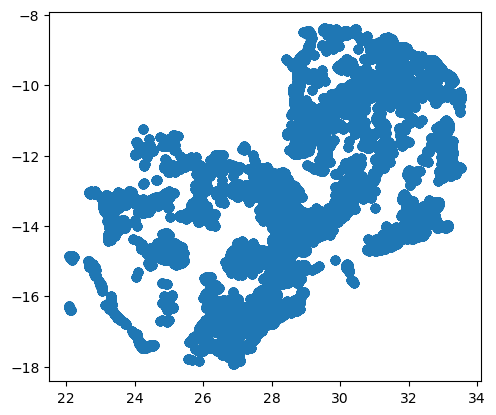

In [32]:
points.plot()

### Impute missing values

Imputing "manually" by descending group levels imputes NA values in multiple "cascading" steps, decreasing the proportion of inoutated values with each step. First, the NA values are imputed at by both `year` and `district`, which should yield imputed values that most closely match the feature values that would be present in the data if there was no clouds obscuring the satellite images. Next, the remaining NA values that could not be imputed by both `year` and `district` are imputed by only `district`. Lastly, the remaining NA vlaues that could not be imputed by both `year` and `district` or by just `district` are imputed by `year` only. This option gives the user more control and transparency over how the imputation is executed.

Imputing using `scikit learn`'s simple imputer executes standard imputation, the details of which can be found in the `scikitlearn` documentation [here.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

The imputation approach depends on the selection made at the top of this notebook for `impute_manual`.

In [33]:
# compute the number of cells in the features dataframe, based on the amount of rows (images), months, and feature columns
num_cells = len(features) * len(month_range) * num_features

In [34]:
class bcolors:
    BL = '\x1b[1;34m' #GREEN
    GR = '\x1b[1;36m' #GREEN
    YL = '\x1b[1;33m' #YELLOW
    RD = '\x1b[1;31m' #RED
    RESET = '\033[0m' #RESET COLOR

In [35]:
%%time
if impute_manual:
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Starting total row count: {bcolors.BL}{ln_ft}{bcolors.RESET}',
          f'\nPre-Impute NaN row count: {bcolors.RD}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPre-Impute NaN row %: {bcolors.RD}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPre-Impute NaN cell %: {bcolors.RD}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 1: Filling NaN values by month, year, and district group average')
    features = (
        features
        .fillna(features
                .groupby(['year', 'district'], as_index=False)
                .transform('mean')
               )
    )
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Post step 1 NaN row count: {bcolors.YL}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPost step 1 NaN row %: {bcolors.YL}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPost step 1 NaN cell %: {bcolors.YL}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 2: Filling NaN values by month and district across group average')
    features = (
        features
        .fillna(features
                .groupby(['district'], as_index=False)
                .transform('mean')
               )
    )
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Post step 2 NaN row count: {bcolors.GR}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPost step 2 NaN row %: {bcolors.GR}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPost step 2 NaN cell %: {bcolors.GR}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 3: Drop remaining NaN values\n')
    features = features.dropna(axis=0)
    print(f'Ending total row count: {bcolors.BL}{len(features)}{bcolors.RESET}')
else:
    features = features.set_index(['year', 'district'])
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit_transform(features)
    features[:] = imputer.transform(features)
    features = features.reset_index()

Starting total row count: 254774 
Pre-Impute NaN row count: 247448 
Pre-Impute NaN row %: 97.12 
Pre-Impute NaN cell %: 29.32 

Step 1: Filling NaN values by month, year, and district group average
Post step 1 NaN row count: 226390 
Post step 1 NaN row %: 88.86 
Post step 1 NaN cell %: 19.03 

Step 2: Filling NaN values by month and district across group average
Post step 2 NaN row count: 520 
Post step 2 NaN row %: 0.20 
Post step 2 NaN cell %: 0.02 

Step 3: Drop remaining NaN values

Ending total row count: 254254
CPU times: user 15min 44s, sys: 2min 18s, total: 18min 2s
Wall time: 17min 49s


### Save copy of processed features before sumarizing training features to district level

Duplicate the features dataframe at this stage so we can retain a copy of features at point resolution for all years available, which is `2013/2014/2016-2021`.

    - The start year is `2016` if the satellite selected is Sentinel 2 (due to the fact that Sentinel 2 launched in June of `2015`)
    - The start year is `2013` if the satellite selected is Landsat 8 and the month range selected was anything besides all months (due to the fact that Landsat 8 launched in February of `2013`)
    - The start year is `2014` if the satellite selected is Landsat 8 and the month range selected was all months
    
This duplicated dataframe we create in the following code is called `features_all_years`. The purpose for this dataframe comes into play after the model is trained; we will be able to plug in point-resolution features from _any and all_ years from this dataframe into the trained model and observe how the model predicts crop years across space and time. It would be interesting to plot these features for each year sequentially to show how the crop prediction landscape changes by year. These point-resolution features increase the spatial resolution of the ground-truth crop data we have for the years through 2018, because our ground-truth crop data is at a the coarser  district-resolution. Furthermore, these point-resolution features are the _only_ crop data we have for the years 2020-2021. The reason we lack data from 2019 is because the Zanbia Sattistics Agency has not yet released their Crop Forecast Survey data for that year. The reason we do not have data for 2020-2021 is because Covid-19 prevented any Crop Forecast Surveys from being conducted. 


After we create the dataframe `features_all_years`, we are free to further process the original features dataframe, `features`, in order to train the model with these features and their paired ground-truth crop yields. Processing this dataframe further requires us to subset the years to the start year through the years for which we have crop data: `2013/2014/2016-2019`. This dataframe is called `features_through_2019`. The reason we subset this dataframe is because we are training the model using _supervised_ machine learning, which means we are feeding it only features that have ground-truth crop data accosicated with them.

In [36]:
features_all_years = features.copy()

# assign the geometry column to features_2014_2021 so it can serve 2 purposes:
# 1. plotting features sequentially by year
# 2. the entire dataframe can be fed into the model after the model is trained on only the summarized features for 2014-2018 and the associated crop data
features_all_years['geometry'] = points.geometry
# moving forward in the immediate sections, summarize the `features` dataframe to district level

### Subset the `features` dataframe to the years `2013/2014/2016-2019`

As discussed above, all feature data required the previous processing steps. However, the following code is not executed on _all_ features.
1. The `2013/2014-2019` (Landsat 8) or `2016-2019` (Sentinel 2) set of features is named `features_through_2019` so the name is agnostic to the selected satellite and month range.
2. The features in each row (point) in `features_through_2019` will be summarized to administrative boundary level (all rows (points) have already been assigned to the district in which they reside).
2. These summarized features in `features_through_2019` will then be joined with the district-resolution crop data. Next, we split these features into train and test sets, and then use them to train the model using ridge regression.
3. Lastly, apply the trained model to the larger, comprehensive feature set for `2013/2014-2021` (Landsat 8) or `2016-2021` (Sentinel 2), called `features_all_years`, which includes all years regardless if those years have ground truth crop data. 

After we train the model, recall that we are _most interested_ in generating crop predictions for the three years `2020-2021` because the model was not trained on these years at all, and it is an "out-of-bag sample" in machine learning terms. The following code splits the data correctly no matter which satellite was selected at the top of the notebook.

In [37]:
# subset the features dataframe to just the years 2013/2014/2016-2019
# this will allow us to join these years to the crop data over space and time in the next section
features_through_2019 = features[features.year <= year_end_crops]

# check that subsetting years worked
print(features_through_2019["year"].unique())
# output should be 2016, 2017, 2018, 2019 for Sentinel 2
# output should be 2013/2014, 2015, 2016, 2017, 2018, 2019 for Landsat 8

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]


### Summarise to administrative boundary level
Weighted by cropped area, or simple mean, depending on the selection at the top of this notebook for `weighted_avg`. 

In [38]:
# check the order of the columns in the dataframe that will be summarized and then fed into the ridge regression in order to train the model
# we care about the order of columns specifically because in the following steps we assign only the feature columns to an object, so we need to know which 3 columns to omit by indexing
features_through_2019.columns

Index(['year', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7', '0_8', '0_9',
       ...
       '1023_5', '1023_6', '1023_7', '1023_8', '1023_9', '1023_10', '1023_11',
       '1023_12', 'crop_perc', 'district'],
      dtype='object', length=12291)

The output above show that the 3 columns that are _not_ features are the first 2 columns `year` and `district`, and the last column, `crop_perc`.

In [39]:
# check the shape to the dataframe as a sanity check
features_through_2019.shape

(254254, 12291)

The output above shows the number of rows and columns in the dataframe, respectively. Recall that the number of rows represents the number of points for which we have features, and the number of columns is all features for all months selected plus the columns `year`, `district`, and `crop_perc`. There are 13866 rows, meaning that is the amount of training points we have to feed into the model _before they are summarized to district level_, so this number will shrink after we summarize to district level. There are 12003 columns, which will not change after we summarize the features to district level. The number of columns that we include in the features object in the next chunk will be this number minus the 3 non-feature columns.

In [40]:
# create object that contains only feature columns, rather than all columns that would include `district`, `year`, and `crop_perc`
# python index starts at 0, so here we specify to retain columns starting at 3 through every column besides the last column
# the columns we omit stay in the dataframe, because we assign the selected columns to an object, but the omitted columns are not included in the calculation in the next chunk
var_cols = features_through_2019.columns[2:-1].values.tolist()

# call the object `var_cols` to check that it only includes feature columns, but do not view it in list format because it is more readable not as a list 
features_through_2019.columns[2:-1]
# these are all the feature columns that will be fed into the `weighted_avg` calculation in the next chunk

Index(['0_2', '0_3', '0_4', '0_5', '0_6', '0_7', '0_8', '0_9', '0_10', '0_11',
       ...
       '1023_4', '1023_5', '1023_6', '1023_7', '1023_8', '1023_9', '1023_10',
       '1023_11', '1023_12', 'crop_perc'],
      dtype='object', length=12288)

In [41]:
%%time
# execute the weighted average on the cropped area
# if the object `weighted_avg` was set to True at the top of the notebook, this calculation gives more weight (importance) to area in Zambia that has a high proportion of cropland
# this differs from the masking step that was executed earlier, because the masking step completely removed all land that was 0% cropland, and this step processes the land that is >1% cropland
if weighted_avg:
    features_summary = (
        features_through_2019
        .groupby(['year', 'district'], as_index=False)
        .apply(lambda x: pd.Series([sum(x[v] * x.crop_perc) / sum(x.crop_perc) for v in var_cols]))
    )
# if weighted_avg was set to FALSE at the beginning of the notebook, the weighted avergae is not executed
# instead, the features are simply summarized by district and year, which also occurred above if weighted_avg was set to TRUE
else:
    features_summary = features_through_2019.groupby(['district',"year"], as_index = False).mean()
# now that we have renamed our features object to `features_summary`, note that we use this object moving forward

CPU times: user 6.97 s, sys: 287 ms, total: 7.26 s
Wall time: 7.26 s


Now that the features have been summarized to district and year, there are fewer rows. The dataframe we were working with before this step,  `features_through_2018`, had 13866 rows that represented points. Now we have 216 rows, as shown by the following output. Notice we still have all 12003 columns. 

In [42]:
features_summary.shape

(923, 12291)

### Join crop data

Combine the crop data and features into 1 dataframe in order to train the model on this object in the next section. The crop data is at district-resolution, as is the feature data in the dataframe `features_summary`.

In [43]:
# remind yourself of the object `crop_df` we created much earlier in the notebook when we read in the crop data in the section "Crop yield"
crop_df

,year,yield_mt
district,,
Chadiza,2009,1.333924
Chadiza,2010,1.852544
Chadiza,2011,6.846486
Chadiza,2012,2.148661
Chadiza,2013,2.008807
...,...,...
Zambezi,2017,1.490456
Zambezi,2018,1.622273
Zambezi,2019,1.184923


This dataframe needs to undergo a little processing before we can join it to `features_summary`.
1. Firstly, we need to subset the years to just the years for which we have features. 
2. Next, we remove 2 districts. We do this because the district shapefile that we used to assign districts to the feature data does not include the districts Mafinga or Ikelenge. It is not uncommon for district boundaries to change slightly over time in sub-Saharan Africa. This was determined by examining the unique district values in both dataframes before executing the follwoing chunk.
3. Lastly, we reset the index so all 3 variables are columns.

In [44]:
# take subset of crop dataframe so that it only includes the years for which we have feature data, through 2018
# this subsets the dataframe correctly no matter which satellite was selected
# COME BACK TO THIS PART TO DETEMRINE HOW TO HANDLE +1 
# delete: crop_through_2018 = crop_df[crop_df.year >= year_start]
# delete: crop_through_2018 = crop_df[crop_df.year >= year_start + 1]
# suggested change:
crop_through_2019 = crop_df[crop_df.year >= min(features_summary.year)]

# now the crop data starts in 2013, 2014 or 2016, depending on which satellite was selected and which month range was selected
# remove 2 districts because they are not present in one shapefile 
crop_through_2019 = crop_through_2019[~crop_through_2019.index.isin(['Mafinga', 'Ikelenge'])]
# reset index so all 3 variables are columns
crop_through_2019.reset_index(inplace = True)
# take a look at the crop dataframe as a sanity check that the processing steps were correct
# the `yield_mt` data is in units of metric tonnes per hectare of cropland planted
crop_through_2019
# if interested, please see more details about the crop data in our technical documentation for this project

,district,year,yield_mt
0,Chadiza,2009,1.333924
1,Chadiza,2010,1.852544
2,Chadiza,2011,6.846486
3,Chadiza,2012,2.148661
4,Chadiza,2013,2.008807
...,...,...,...
931,Zambezi,2017,1.490456
932,Zambezi,2018,1.622273
933,Zambezi,2019,1.184923
934,Zambezi,2020,1.689628


Now remind yourself of the columns of the features dataframe so we know which column(s) we can use to join the dataframes:

In [45]:
features_summary.columns

Index(['district', 'year', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7',
       '0_8',
       ...
       '1023_4', '1023_5', '1023_6', '1023_7', '1023_8', '1023_9', '1023_10',
       '1023_11', '1023_12', 'crop_perc'],
      dtype='object', length=12291)

The columns we can join by are `district` and `year`.

In [46]:
# join the crop data with the summarized feature data through 2019
features_summary = (
    features_summary
    .set_index(["district", "year"])
    .join(other = crop_through_2019.set_index(["district", "year"]))
    .reset_index())

features_summary.columns
# now that the data is joined, the column `yield_mt` is present in `features_summary`

Index(['district', 'year', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7',
       '0_8',
       ...
       '1023_5', '1023_6', '1023_7', '1023_8', '1023_9', '1023_10', '1023_11',
       '1023_12', 'crop_perc', 'yield_mt'],
      dtype='object', length=12292)

Now that the summarized features are joined to the crop data, each row represents summarized features for a district for one year. For example, the top rows of this dataframe show the district Chadiza for several years, then the district switches to Chama, with a Chama row for each year, and so on all the way through the districts until the last one, Zambezi.

In [47]:
features_summary

,district,year,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,1023_5,1023_6,1023_7,1023_8,1023_9,1023_10,1023_11,1023_12,crop_perc,yield_mt
0,Chadiza,2009,0.670399,0.415835,0.768477,0.419546,0.466701,0.458289,0.368062,0.421814,...,0.008362,0.001617,0.002141,0.002332,0.007558,0.001501,0.027334,0.009416,0.787985,1.333924
1,Chadiza,2010,0.670399,0.859507,0.587414,0.423193,0.475172,0.568628,0.622875,0.378504,...,0.002324,0.006256,0.004295,0.007296,0.002397,0.049026,0.027334,0.009416,0.787985,1.852544
2,Chadiza,2011,0.670399,0.415835,0.587414,0.401055,0.439361,0.568628,0.622875,0.437702,...,0.018489,0.006256,0.004295,0.002879,0.004023,0.011755,0.027334,0.009416,0.787985,6.846486
3,Chadiza,2012,0.670399,0.415835,0.323083,0.508433,0.431334,0.568628,0.622875,0.293290,...,0.001910,0.006256,0.004295,0.007178,0.002990,0.048927,0.131111,0.009416,0.787985,2.148661
4,Chadiza,2013,0.670399,0.415835,0.340238,0.497872,0.589249,0.511726,0.435890,0.490173,...,0.002259,0.006596,0.001100,0.003712,0.003952,0.013919,0.097730,0.009416,0.787985,2.008807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,Zambezi,2017,0.446204,0.954878,0.469761,0.260954,0.291071,0.350037,0.296390,0.248623,...,0.011604,0.013372,0.013021,0.014927,0.002386,0.011856,0.016026,0.019243,0.312756,1.490456
919,Zambezi,2018,0.762739,0.782818,0.078429,0.185016,0.319580,0.268584,0.391607,0.409445,...,0.008463,0.016542,0.010382,0.005346,0.018952,0.010367,0.001137,0.008122,0.312756,1.622273
920,Zambezi,2019,0.208967,0.157758,0.163247,0.576215,0.283152,0.378008,0.422447,0.317314,...,0.011704,0.012647,0.005830,0.005208,0.014522,0.014802,0.012475,0.000000,0.312756,1.184923
921,Zambezi,2020,0.902294,0.294597,0.199603,0.160704,0.301211,0.411793,0.386602,0.374459,...,0.011378,0.006453,0.013931,0.004067,0.007563,0.004809,0.006255,0.009290,0.312756,1.689628


## Model

### Define `x`'s and `y`'s that will be a part of training the model

Since our independent variable is the features, these are the `x`'s. Our dependent variable is the crop yield in metric tonnes per hectare planted, so that will be the `y`'s.

In [48]:
# this if-else statement is determined by the selection of True or False made at the top of the notebook for the object `weighted_avg`
if weighted_avg:
    drop_cols = ['district', 'year', 'yield_mt']
else:
# if the selection was False, we can drop the `crop_perc` columns because we will not use it moving forward
    drop_cols = [
        # 'district', 
        'year', 'yield_mt', "crop_perc"]
# note that this chunk does not actually execute the column dropping, it just defines the object that will determine which are dropped in the next chunk

In [49]:
# define ALL x's (the features_summary data that will be fed into the model to train) by dropping the columns specified in the previous chunk
# if the `axis` argument was set to 0, this code would incorrectly drop rows instead of columns
# x_all = features_summary.drop(drop_cols, axis = 1)

x_all = pd.get_dummies(features_summary, 
                       columns=["district"], 
                       drop_first=False)
x_all = x_all.drop(drop_cols, axis = 1)


# log transform the `yield_mt` column because that was recommended by the client
y_all = np.log10(features_summary.yield_mt.to_numpy() + 1)

In [50]:
# take a look at the first 10 values of the log transformed `yield_mt` array to get an idea of the scale of the crop yields we use to train the model
print(y_all[:10])

[0.36808667 0.45523235 0.89467521 0.49812592 0.47839429 0.53241132
 0.48045774 0.45885334 0.58916141 0.36159167]


### Split into train and test sets

This step is executed right before training the model so we can train on 80% of the data and preserve 20% for testing.

In [51]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size = 0.2, random_state = 0
)

In [52]:
print("Number of total points: ", len(x_all), "\n", 
      "Number of training points: ", len(x_train), "\n",
      "Number of testing points: ", len(x_test), sep = "")

Number of total points: 923
Number of training points: 738
Number of testing points: 185


### Train model using cross-validated ridge regression

Please see the documentation for the function that executes this regression [here.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)

In [53]:
ridge_cv_random = RidgeCV(cv = 5, alphas = np.logspace(-8, 8, base = 10, num = 17))
ridge_cv_random.fit(x_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

In [54]:
print(f"Estimated regularization parameter: {ridge_cv_random.alpha_}")

Estimated regularization parameter: 10.0


### Validation set $R^2$ performance

In [55]:
print(f"Validation R2 performance: {ridge_cv_random.best_score_:0.2f}")

Validation R2 performance: 0.57


### Train set

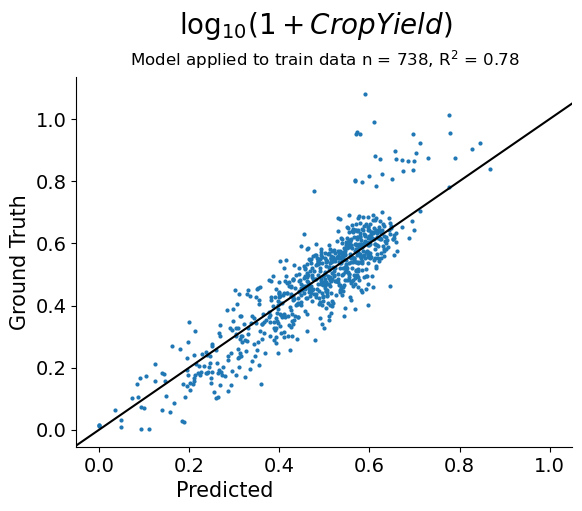

In [56]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)
r2_train = r2_score(y_train, y_pred)

fig, ax = plt.subplots(ncols=1)
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {r2_train:0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.axline([0, 0], [1, 1], c = "k")

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()
# the model is plotted with a black 45 degree line that serves as a reference of what a perfect correlation would look like
# deviation of the line indicates that there is not a perfect correlation

In [57]:
print(f"Training R^2 = {r2_train:0.2f}\nPearsons r = {pearsonr(y_pred, y_train)[0]:0.2f}") 

Training R^2 = 0.78
Pearsons r = 0.88


In [58]:
# Pearson r^2
pearsonr(y_pred, y_train)[0] ** 2

0.7815089181321235

In [59]:
# alternative way to calculate Training R^2
ridge_cv_random.score(x_train, y_train)

0.7755721250587522

### Test set

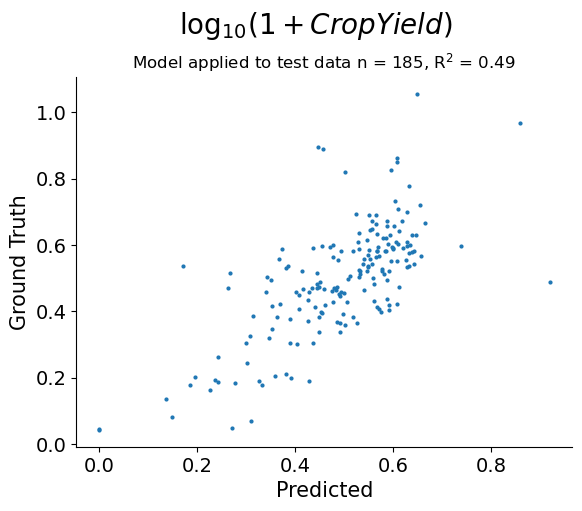

In [60]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)
r2_test = r2_score(y_test, y_pred)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {r2_test:0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.axline([0, 0], [.75, .75], c = "k")

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [61]:
print(f"Testing set R^2 = {r2_test:0.2f}")
print(f"Testing set pearsons R = {pearsonr(y_pred, y_test)[0]:0.2f}")

Testing set R^2 = 0.49
Testing set pearsons R = 0.71


Summary of both train and test data sets

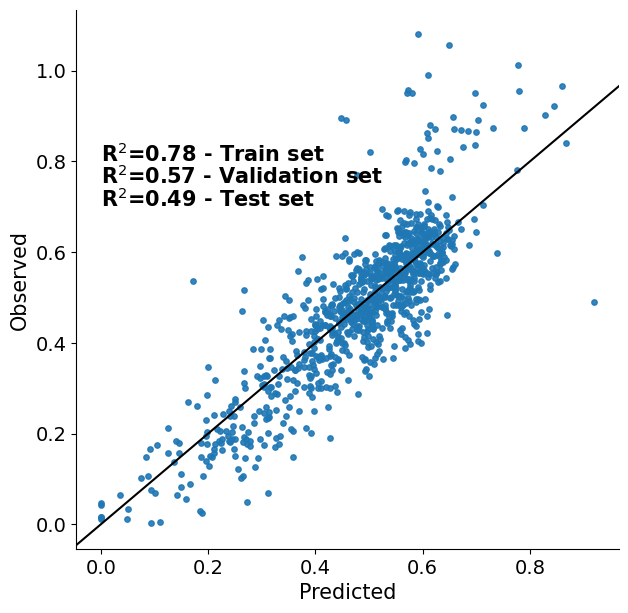

In [62]:
y_pred = np.maximum(ridge_cv_random.predict(x_all), 0)

fig, ax = plt.subplots(figsize=(7, 7))
ax.axline([0, 0], [.75, .75], c = "k")
plt.scatter(y_pred, y_all, alpha=.9, s=15)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Observed", fontsize=15)
plt.text(
    0, .8, fontsize=15, fontweight="bold",
    s=f"R$^2$={r2_train:0.2f} - Train set",
)
plt.text(
    0, .75, fontsize=15, fontweight="bold",
    s=f"R$^2$={ridge_cv_random.best_score_:0.2f} - Validation set",
)
plt.text(
    0, .7, fontsize=15, fontweight="bold",
    s=f"R$^2$={r2_test:0.2f} - Test set",
)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_all_data.jpg', dpi=300)
plt.show()
plt.close()

### Use the trained model to predict crop yields over all years from 1km grid-cell resolution features 

Recall that after we executed imputation on all feature years in the dataframe `features`, we copied the dataframe and named it `features_all_years`. Now we can plug that into the model to visualize how our model performs over time.

In [63]:
# recall the object we created earlier, before we split the features by year into those that would train the model 
# and those that would be fed into the trained model to predict crop yields
# in years for which we do not have crop data
features_all_years.head(3)

,year,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,1023_6,1023_7,1023_8,1023_9,1023_10,1023_11,1023_12,crop_perc,district,geometry
0,2009,0.454439,0.502102,0.068686,0.250473,0.337390,0.485332,0.647679,0.000153,0.399850,...,0.000046,0.000000,0.643495,0.005516,0.003225,0.004282,0.125096,0.1279,Kalabo,POINT (22.07488 -14.86423)
1,2010,0.956612,0.368983,0.329758,0.169845,0.313996,0.287629,0.295129,0.255007,0.235734,...,0.006424,0.007702,0.013589,0.013095,0.011051,0.005477,0.014699,0.1279,Kalabo,POINT (22.07488 -14.86423)
2,2011,0.454439,0.424619,0.111051,0.159344,0.185883,0.287629,0.295129,0.377354,0.266691,...,0.006424,0.007702,0.028948,0.014299,0.009329,0.018889,0.029986,0.1279,Kalabo,POINT (22.07488 -14.86423)


In the following chunk, we drop certain columns from `features_all_years` because we only need to feed the feature data into the model to generate predictions. Using the argument `axis = 1`, we specify that we are dropping columns rather than rows. 

In [64]:
x_all = features_all_years.drop([
    'year', 
    'geometry',
    'district',
    'crop_perc'
], axis = 1)

In the following chunk, we execute the model on the features from the dataframe `features_all_years`. The crop yield predictions for each row populate a new column in the dataframe.

The model is run inside the `np.maximum()` function because if we run it without being wrapped inside function, some crop predictions are negative values, but we need them all to be positive because conceptually crop yields cannot be negative.

In [65]:
features_all_years['yield_prediction'] = np.maximum(ridge_cv_random.predict(x_all), 0)

/home/computevmuser/miniconda3/envs/mosaiks-env/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- district_Chadiza
- district_Chama
- district_Chavuma
- district_Chibombo
- district_Chiengi
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 12288 features, but RidgeCV is expecting 12359 features as input.

In [ ]:
# check out the dataframe with the new column of predictions
features_all_years.head(3)

The dataframe is already a geodataframe, so we do not have to convert it to one before mapping predictions. However, we do need to replace all the zero value crop percentage areas with `NA`. We do this by applying the `mask()` function. This function is similar to an if-else statement. If the value of the `crop_perc` is equal to 0, that value is replaced by the value of the second argument, which is `NA`. If the value of `crop_prec` is _not_ equal to zero, we retain the current value. The argument `inplace = True` executes this replacement in the same cell. 

In [ ]:
features_all_years['yield_prediction'].mask(features_all_years['crop_perc']==0, np.nan, inplace=True)

Recall that this dataframe has a geometry column, with latitude and longitude together. In order to map the predicted features, we separate this geometry column into separate `lon` and `lat` columns. 

In [ ]:
# extract the longitude and latitude from the geometry column, and make then into independent columns
features_all_years['lon'], features_all_years['lat'] = features_all_years.geometry.x, features_all_years.geometry.y

Plot the predicted features for each year:

In [ ]:
def scatter(x, y, c, **kwargs):
    plt.scatter(x, y, c=c, s = 1.25)
sns.color_palette("viridis", as_cmap=True)
g = sns.FacetGrid(
    features_all_years, 
    col="year", 
    col_wrap = 4, 
    height=5, 
    aspect=1
)
g.map(scatter, "lon", "lat", "yield_prediction")
g.set_axis_labels(r"Yield Prediction")
# save the figure and name the file so that it represents the model parameters that created the predictions
# plt.savefig(f'images/{feature_file_name}_all_predictions.jpg', dpi=300)

Plot the model's predicted features summarized to district level. In this visualization, we choose a specific year to examine rather than visualizing all years in one figure. Visualizing the the features summarized to district level is interesting because the crop data resolution provided by Zambia Statistics Agency is at the district level, and therefore it is easier to compare our model results to those ground-truth values when they are summarized to district level as well. Furthermore, our model's crop predictions for the years 2020 and 2021 might be more valuable when summarized to district level if Zambian governments, policy-makers, farmers, and researchers wish to use this data to determine crop imports, exports, and storage according to district summaries. 

In [ ]:
features_all_years_summary = (
    features_all_years
    .groupby(['district',"year"], as_index = False)['yield_prediction']
    .mean()
    .set_index('district')
)

In [ ]:
# join Zambia's shapefile to the summarized features to map the districts
# reset the index so it is a properly formatted dataframe
features_all_years_summary = features_all_years_summary.join(country_shp).reset_index()

Now that the geometries have been converted to districts from points, the geomatries are now polygons. There is still a row for each district for each year.

In order to change the year visualized, simply change the year in the following code and re-run the chunk.

In [ ]:
# features_all_years_summary[features_all_years_summary.year == 2020].plot(column = "yield_prediction")

Plot a boxplot for each year to visualize the range and quantile distribution of each year's crop predictions, summarized to district level. This enables us to identify years with exceptional disparities between the predicted yields by district. It also allows us to identify years that have many outliers.

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x="year", y="yield_prediction", data = features_all_years_summary)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Predicted Yield", fontsize=15)

Visualize the total crop yield predictions by year. This bar chart shows the sum of all the district crop yields.

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x="year", y="yield_prediction", data = features_all_years_summary, estimator = sum)

## Yield and Residual Plots

Create a dataframe of residuals called `residuals_df` from the `features_summary` dataframe. Note that we are _not_ using the predicted crop yields for _all_ years for these residuals, but rather the ground-truth crop yields for just the years through 2018.

The residuals give us an idea of the amount of uncertianty that is present in our model. By demeaning the residuals over space, we are able to remove the uncertainty over space and better determine our model performance over time and our uncertainty over time.

In [ ]:
x_all = features_summary.drop(drop_cols, axis = 1)

# create empty dataframe to then populate with columns
residual_df = pd.DataFrame()

residual_df["yield_mt"] = features_summary.yield_mt.to_numpy()
residual_df["log_yield"] = np.log10(features_summary.yield_mt.to_numpy() + 1)
residual_df["prediction"] = np.maximum(ridge_cv_random.predict(x_all), 0)
residual_df["residual"] = residual_df["log_yield"] - residual_df["prediction"]
residual_df["year"] = features_summary.year
residual_df["district"] = features_summary.district
# join the district geometries
residual_df = residual_df.join(country_shp, how = "left", on = "district")

# demean by location so we can analyze the data over time
residual_df["district_yield_mean"] = residual_df.groupby('district')['log_yield'].transform('mean')
residual_df["district_prediction_mean"] = residual_df.groupby('district')['prediction'].transform('mean')
residual_df["demean_yield"] = residual_df["log_yield"] - residual_df["district_yield_mean"]
residual_df["demean_prediction"] = residual_df["prediction"] - residual_df["district_prediction_mean"]
residual_gdf = geopandas.GeoDataFrame(residual_df)

residual_gdf.head(3)

Visualize the residuals for the ground truth crop yields through 2018 with a boxplot.

In [ ]:
plt.figure(figsize=(6, 5))
sns.boxplot(x="year", y="log_yield", data=residual_df)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Log Yield", fontsize=15)

Visualize the residuals as a sum by year with a bar plot.

In [ ]:
plt.figure(figsize=(6, 5))
sns.barplot(x="year", y="log_yield", data=residual_df, estimator = sum)

Visualize the crop yield residuals by year as a histogram to determine how they are distributed.

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "yield_mt", bins = 20)
g.set_axis_labels("Yield (MT)")

Visualize the log-transformed crop yield residuals by year as a histogram to compare how they are distributed after the transformation.

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "log_yield", bins = 20)
g.set_axis_labels(r"$\log_{10}(1 + Crop Yield)$")

#### Crop prediction histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "prediction", bins = 20)
g.set_axis_labels(r"Crop yield predictions")

#### Residual histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "residual", bins = 20)
g.set_axis_labels(r"Residuals")

In [ ]:
residual_gdf.residual.min()

In [ ]:
residual_gdf.residual.max()

#### Log crop yield vs residuals

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.scatterplot, "log_yield", "residual")
g.set_axis_labels(r"$\log_{10}(1 + Crop Yield)$")

#### District residuals 

In [ ]:
if satellite == 'landsat-8-c2-l2':
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    ax1 = (residual_gdf[residual_gdf.year == 2014]
           .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
           .set_title("2014 Residuals"))
    ax2 = (residual_gdf[residual_gdf.year == 2015]
           .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
           .set_title("2015 Residuals"))
else:
    pass
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax1 = (residual_gdf[residual_gdf.year == 2016]
       .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2016 Residuals"))
ax2 = (residual_gdf[residual_gdf.year == 2017]
       .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2017 Residuals"))
ax3 = (residual_gdf[residual_gdf.year == 2018]
       .plot(ax = ax3, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2018 Residuals"))

caption = "A positive value is an underestimated prediction (the prediction is lower than the actual yield), a negative value is an over estimated prediction"
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)


#### Difference from the mean

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.scatterplot, "demean_yield", "demean_prediction")
g.set_axis_labels('Difference from Yield Mean', 'Difference from Prediction Mean')

In [ ]:
fig, ax = plt.subplots(figsize= (6, 5))
ax.axline([-.2, -.2], [.4, .4], c = "k")
plt.scatter(residual_gdf.demean_yield, residual_gdf.demean_prediction)
plt.title("Demeaned truth and predictions by district")
plt.xlabel('Difference from Yield Mean')
plt.ylabel('Difference from Predictions Mean')
r_squared = r2_score(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
plt.text(
    -0.2,
    .18,
    s=f"Demeaned R$^2$ = {r_squared:0.2f}",
    fontsize=15,
    fontweight="bold",
)
# plt.savefig(f'images/{feature_file_name}_demean.jpg', dpi=300)

In [ ]:
for yr in range(year_start+1, 2018):
    r_squared = r2_score(residual_gdf[residual_gdf.year == yr]["demean_yield"], residual_gdf[residual_gdf.year == yr]["demean_prediction"])
    pearson_r = pearsonr(residual_gdf[residual_gdf.year == yr]["demean_yield"], residual_gdf[residual_gdf.year == yr]["demean_prediction"])
    
    print(yr, f"    R^2: {r_squared:.2f}\n",
          f"Pearson's r: {pearson_r[0]:.2f}\n", 
          sep = "")
    
r_squared = r2_score(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
pearson_r = pearsonr(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
print(f"All     R^2: {r_squared:.2f}\n",
      f"Pearson's r: {pearson_r[0]:.2f}", sep = "")

In [ ]:
r2 = round(pearson_r[0] ** 2, 2)
r2

#### Join residuals to the features for _all_ years to visualize the residuals of the features before they were summarized to district level.

In [ ]:
complete_df = (
    features_all_years_summary
    .set_index(['district', 'year'])
    .join(residual_df
          .drop('geometry', axis = 1)
          .set_index(['district', 'year'])
         )
    .reset_index()
)

complete_df.head(3)

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = complete_df.melt(id_vars='year').rename(columns=str.title)
tidy = tidy[tidy.Variable.isin(['yield_prediction', 'log_yield'])]
sns.barplot(x='Year', y='Value', hue='Variable', data=tidy, ax=ax1, ci = None)
sns.despine(fig)

h, l = ax1.get_legend_handles_labels()
ax1.legend(h, ['Predicted Yield', 'Observed Yield'],loc='lower left')

# plt.savefig(f'images/{feature_file_name}_yield_pred.jpg', dpi=300)

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x="year", y="yield_prediction", data=complete_df, estimator = sum)

### Congratulations on completing this analysis!